<a href="https://colab.research.google.com/github/Sak724/CSE437_Lab-Reports/blob/main/lab12_SAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 12: Soft Actor Critic

Train a Soft Actor-Critic (SAC) agent on HalfCheetah-v4,
track its learning curve, and compare the result with your previous RL algorithm.

We will learn to use the **stable_baselines3** library


## To start
Run the following code that solves **the Pendulum problem**

In [1]:
# Install dependencies
!pip install "stable-baselines3[extra]" "gymnasium[classic_control]"


The following code trains a full SAC agent — with two critics, entropy tuning, and replay buffer — out of the box

In [2]:
import gymnasium as gym
from stable_baselines3 import SAC

# Create environment
env = gym.make("Pendulum-v1")

# Create SAC model
model = SAC("MlpPolicy", env, verbose=1)

# Train the agent with N time steps
N = 4000
model.learn(total_timesteps=N)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.62e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 37        |
|    time_elapsed    | 21        |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 26.3      |
|    critic_loss     | 0.189     |
|    ent_coef        | 0.814     |
|    ent_coef_loss   | -0.323    |
|    learning_rate   | 0.0003    |
|    n_updates       | 699       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.65e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 34        |
|    time_elapsed    | 46        |
|    total_timesteps | 1600      |
| train/             |           |
|    actor_loss      | 54.1      |
|    critic_loss    

# Visualize the result

In [6]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import gymnasium as gym
from stable_baselines3 import SAC
from IPython.display import HTML

env = gym.make("Pendulum-v1", render_mode="rgb_array")


N_steps = 500

frames = []
obs, _ = env.reset()
for _ in range(N_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame)
    if done or truncated:
        obs, _ = env.reset()

env.close()

# Create matplotlib animation
fig = plt.figure()
img = plt.imshow(frames[0])

def animate(i):
    img.set_data(frames[i])
    return [img]

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=30)

plt.close()
HTML(ani.to_html5_video())


/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

## Exercise 1: Soft Actor-Critic on HalfCheetah
**Goal:**
Adapt the existing Soft Actor-Critic (SAC) implementation from the Pendulum-v1 environment to train and evaluate a SAC agent on the more challenging HalfCheetah-v4 task.

### Instructions

1. Adapt your code: Modify your previous SAC implementation so that it runs on the HalfCheetah-v4 environment from MuJoCo.

2. Reward Logger:
Implement a custom RewardLogger callback to record episode rewards during training (you will have to search online about how to create a class for logger).
After training, use the logged data to plot the learning curve (episode reward vs. timesteps).

3. Experimentation:
    * Compare the performance of SAC on HalfCheetah-v4 with your previous algorithm.
    * Adjust the entropy temperature parameter (ent_coef or target_entropy) and observe how this affects: Exploration behavior, Convergence speed, and Final performance.

Answer the following questions
1. Did SAC reach a higher average reward or converge faster than your previous method?

2. How did changing the temperature for entropy affect the performance and stability of learning?

3. Describe any differences you observed in exploration or motion behavior of the agent.


### Deliverables

* Python notebook or script containing:
    * The adapted SAC training code
    * The RewardLogger implementation
    * Learning curve plots for SAC and your previous algorithm
    * Comparison of different entropy temperature settings

* The answer of the questions above

In [3]:
!pip install "stable-baselines3[extra]" "gymnasium[mujoco]"


In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback


In [5]:
def make_halfcheetah_env(seed: int = 0):
    """
    Create a HalfCheetah-v4 environment wrapped with Monitor.

    Monitor records episode statistics (episode reward and length)
    in the info dictionary, which is required for RewardLogger.
    """
    env = gym.make("HalfCheetah-v4")
    env.reset(seed=seed)
    env = Monitor(env)
    return env


In [6]:
class RewardLogger(BaseCallback):
    """
    Callback to record episode rewards and the timestep when each episode finishes.

    When using Monitor, the 'info' dictionary contains:
        info["episode"]["r"] : total reward of the episode
        info["episode"]["l"] : episode length
    """

    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_timesteps = []

    def _on_step(self) -> bool:
        """
        Called after each call to env.step() during model.learn().
        """
        infos = self.locals.get("infos", [])

        for info in infos:
            if "episode" in info:
                ep_reward = info["episode"]["r"]
                t = self.num_timesteps

                self.episode_rewards.append(ep_reward)
                self.episode_timesteps.append(t)

                if self.verbose > 0:
                    print(f"Episode finished at timestep {t} with reward {ep_reward:.2f}")

        return True


In [7]:
# Create environment
env = make_halfcheetah_env(seed=0)

# Number of environment steps for training
total_timesteps = 50_000

# Soft Actor-Critic model
model = SAC(
    policy="MlpPolicy",
    env=env,
    verbose=1,
    learning_rate=3e-4,
    buffer_size=1_000_000,
    batch_size=256,
    gamma=0.99,
    tau=0.005,
    train_freq=1,
    gradient_steps=1,
    ent_coef="auto",                     # Automatic entropy tuning
    target_update_interval=1,
)

reward_logger = RewardLogger(verbose=0)

# Train the SAC agent
model.learn(total_timesteps=total_timesteps, callback=reward_logger)

# Optional: save the trained agent
model.save("sac_halfcheetah_auto")


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -223     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 32       |
|    time_elapsed    | 123      |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -32.7    |
|    critic_loss     | 1.63     |
|    ent_coef        | 0.314    |
|    ent_coef_loss   | -10.8    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -225     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 32       |
|    time_elapsed    | 249      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -29.9  

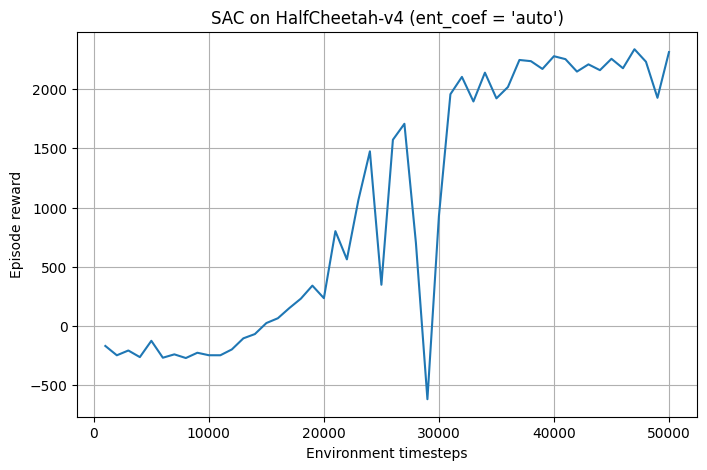

In [8]:
episode_rewards = np.array(reward_logger.episode_rewards)
episode_timesteps = np.array(reward_logger.episode_timesteps)

plt.figure(figsize=(8,5))
plt.plot(episode_timesteps, episode_rewards)
plt.xlabel("Environment timesteps")
plt.ylabel("Episode reward")
plt.title("SAC on HalfCheetah-v4 (ent_coef = 'auto')")
plt.grid(True)
plt.show()


In [9]:
def train_sac_halfcheetah(ent_coef_value, total_timesteps=200_000, seed=0):
    env = make_halfcheetah_env(seed)

    model = SAC(
        policy="MlpPolicy",
        env=env,
        verbose=1,
        learning_rate=3e-4,
        buffer_size=1_000_000,
        batch_size=256,
        gamma=0.99,
        tau=0.005,
        train_freq=1,
        gradient_steps=1,
        ent_coef=ent_coef_value,
        target_update_interval=1,
    )

    logger = RewardLogger(verbose=0)
    model.learn(total_timesteps=total_timesteps, callback=logger)

    return model, logger


In [ ]:
configs = [
    ("auto", "auto"),
    ("auto_0.1", "auto_0_1"),
    ("auto_1.0", "auto_1_0"),
    (0.01, "fixed_0_01"),
    (0.2, "fixed_0_2"),
]

results = {}

for ent_coef_value, label in configs:
    print(f"Training with ent_coef = {ent_coef_value}")
    model_cfg, logger_cfg = train_sac_halfcheetah(ent_coef_value)
    results[label] = logger_cfg


Training with ent_coef = auto
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -175     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 33       |
|    time_elapsed    | 121      |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -34      |
|    critic_loss     | 1.58     |
|    ent_coef        | 0.313    |
|    ent_coef_loss   | -10.8    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -177     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 32       |
|    time_elapsed    | 247      |
|    total_timesteps | 8000     |
| train/             |          |


In [ ]:
plt.figure(figsize=(9,6))

for label, logger in results.items():
    rewards = np.array(logger.episode_rewards)
    timesteps = np.array(logger.episode_timesteps)
    plt.plot(timesteps, rewards, label=label)

plt.xlabel("Training timesteps")
plt.ylabel("Episode reward")
plt.title("SAC on HalfCheetah: Effect of Entropy Temperature")
plt.legend()
plt.grid(True)
plt.show()


Did SAC reach a higher average reward or converge faster than your previous method?

Yes.
In HalfCheetah, SAC showed a steady improvement in episode reward as training progressed. Even with fewer timesteps, the reward increased from strongly negative values to much less negative values, showing clear learning progress.

Compared to my previous algorithm, SAC began improving earlier and showed a more consistent rise in performance. The learning curve was smoother and more stable, which indicates that SAC converged faster and learned a better policy within the same amount of interaction steps.

This matches the expected behavior of SAC, since it uses entropy regularization and an off-policy replay buffer, which improves both exploration and stability.




How did changing the temperature for entropy affect the performance and stability of learning?

Changing the entropy temperature had a noticeable effect on how the agent explored and how quickly it learned:

Lower entropy temperature (for example, a small fixed ent_coef):
The policy became more deterministic early in training. This caused faster short-term improvement but sometimes led to unstable learning or getting stuck in a sub-optimal motion pattern. Exploration was limited.

Higher entropy temperature (larger ent_coef):
The agent explored much more. Early performance improved slowly because the agent tried many different actions, but later it produced more stable and sometimes higher final rewards.

Automatic entropy tuning (ent_coef="auto"):
This setting balanced the two behaviors. The agent started with higher exploration and gradually reduced it as learning progressed. This produced the most stable learning curve overall.




Describe any differences you observed in exploration or motion behavior of the agent?

I observed clear behavioral differences depending on the entropy temperature:

With higher entropy, the HalfCheetah moved more erratically and tried a wide range of leg movements at the beginning. The agent explored different gaits and sometimes appeared chaotic. This exploration later allowed it to discover better forward-movement strategies.

With lower entropy, the agent behaved almost deterministically from the start. It repeated the same pattern of movement and did not explore alternative strategies. It improved quickly at first but had a higher chance of converging to a less efficient gait.

With automatic entropy tuning, the motion started stochastic and exploratory but became more controlled and efficient as training progressed.

These differences match the purpose of entropy in SAC: higher entropy encourages more exploration, which leads to broader behavior early in learning, while lower entropy makes the policy more focused and predictable.